### Preprocesamiento

In [1]:
import sys
sys.path.insert(0, '..')
from utils.preprocesamiento import StemmerTokenizer, make_BoW_preprocess

tokenizador = StemmerTokenizer(stem=False)
preprocessing = make_BoW_preprocess(tokenizador,'comment',max_ngram=1,min_ngram=1,mindf=10)

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline

bog_pipeline = Pipeline(
    [("Preprocessing", preprocessing),
    # ("Selection", SelectPercentile(f_classif, percentile=90)),
    ("Clasificador", MultinomialNB())]
)

### Cargar datos

In [3]:
from utils.cargar import df_caso
from utils.preprocesamiento import process_df

caso = 'alicia'
df = df_caso(caso)

df = process_df(df,'comment','sel',verbose=True)

df = df.drop(columns=['user_id','team_id','gender','df','title','opt_left','opt_right','max_num','phase','time','curso'])

df.head()

80 rows found with non string elements for column comment (0.65%)
Deleting 2326 columns for which max target value is over 7 (18.76%)
9991 available rows after processing


,sel,comment
id,,
20310,1,entrega de producto defectuoso no cumple con l...
20311,1,se debe recuperar tiempo perdido
20314,3,"Una contexto como es el de pandemia, es algo m..."
20315,3,Debiese priorizar cumplir con los criterios té...
20400,4,Lo mejor sería intentar apurar un poco el proy...


In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(df, df['sel'], test_size=.25, stratify=df['sel'], random_state=0)

In [5]:
bog_pipeline.fit(df_train,y_train)

/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bag-of-words',
                                                  CountVectorizer(min_df=10,
                                                                  tokenizer=<utils.preprocesamiento.StemmerTokenizer object at 0x7f02514e5e50>),
                                                  'comment')])),
                ('Clasificador', MultinomialNB())])

In [6]:
from sklearn.metrics import classification_report

y_pred = bog_pipeline.predict(df_test)

print("Resultados clasificador Naive-Bayes multinomial")
print(classification_report(y_test, y_pred))

Resultados clasificador Naive-Bayes multinomial
              precision    recall  f1-score   support

           1       0.50      0.54      0.52       540
           2       0.51      0.56      0.53       911
           3       0.40      0.28      0.33       427
           4       0.33      0.25      0.28       270
           5       0.36      0.49      0.42       263
           6       0.26      0.10      0.15        87

    accuracy                           0.45      2498
   macro avg       0.39      0.37      0.37      2498
weighted avg       0.44      0.45      0.44      2498



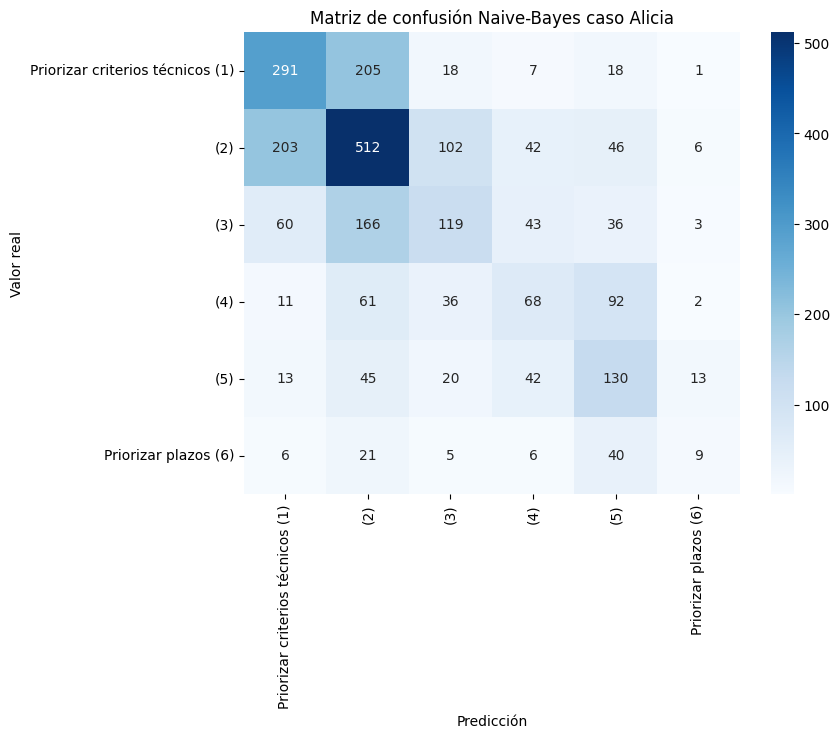

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Example class labels
class_labels = ['Priorizar criterios técnicos (1)', '(2)', '(3)', '(4)', '(5)', 'Priorizar plazos (6)']

# Convert confusion matrix to NumPy array
cm_array = np.array(cm)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels and title
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión Naive-Bayes caso Alicia')

# Show the plot
plt.show()

In [8]:
df.loc[(df['sel']==2) | (df['sel']==3),'sel'] = 1
df.loc[(df['sel']==4) | (df['sel']==5),'sel'] = 6

df.head()

,sel,comment
id,,
20310,1,entrega de producto defectuoso no cumple con l...
20311,1,se debe recuperar tiempo perdido
20314,1,"Una contexto como es el de pandemia, es algo m..."
20315,1,Debiese priorizar cumplir con los criterios té...
20400,6,Lo mejor sería intentar apurar un poco el proy...


In [9]:
df['sel'].value_counts()

1    7512
6    2479
Name: sel, dtype: int64

In [10]:
df_train_binary, df_test_binary, y_train_binary, y_test_binary = train_test_split(df, df['sel'], test_size=.25, stratify=df['sel'], random_state=0)

preprocessing = make_BoW_preprocess(tokenizador,'comment',max_ngram=2,min_ngram=1,mindf=10)

bog_pipeline_binary = Pipeline(
    [("Preprocessing", preprocessing),
    # ("Selection", SelectPercentile(f_classif, percentile=90)),
    ("Clasificador", MultinomialNB())]
)

bog_pipeline_binary.fit(df_train_binary,y_train_binary)

/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bag-of-words',
                                                  CountVectorizer(min_df=10,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<utils.preprocesamiento.StemmerTokenizer object at 0x7f02514e5e50>),
                                                  'comment')])),
                ('Clasificador', MultinomialNB())])

In [11]:
y_pred_binary = bog_pipeline_binary.predict(df_test_binary)

print("Resultados clasificador Naive-Bayes multinomial (binario)")
print(classification_report(y_test_binary, y_pred_binary))

Resultados clasificador Naive-Bayes multinomial (binario)
              precision    recall  f1-score   support

           1       0.89      0.88      0.88      1878
           6       0.64      0.67      0.65       620

    accuracy                           0.83      2498
   macro avg       0.77      0.77      0.77      2498
weighted avg       0.83      0.83      0.83      2498



### Probabilidad por palabra/n_grama en Naive-Bayes

Comenzamos por extraer el vectorizador

In [12]:
vectorizer = bog_pipeline.named_steps['Preprocessing'].transformers_[0][1]
vectorizer

CountVectorizer(min_df=10,
                tokenizer=<utils.preprocesamiento.StemmerTokenizer object at 0x7f0231178760>)

In [13]:
from NB_utils import get_probs, get_top_k_ngrams

prob_1, prob_6 = [], []

for ngram in vectorizer.get_feature_names_out():
    probs = get_probs(ngram,bog_pipeline_binary,df_test_binary,'comment')
    prob_1.append(probs[0])
    prob_6.append(probs[1])


op_left, op_right = 'Producir el alimento', 'Resguardar tradiciones/recurso'

get_top_k_ngrams(10,vectorizer,prob_1,prob_6,op_left,op_right);

Top features 'Producir el alimento':
transparencia 0.9825787794711599
ocultar 0.9823698163306077
mentir 0.9725111252196724
falencia 0.9703483858732489
transparentes 0.969549810405059
podrian 0.969549810405059
transparente 0.9653505095420415
accidentes 0.9644424269694726
esencial 0.96368095683612
falle 0.9598077015758371

Top features 'Resguardar tradiciones/recurso':
supeditado 0.9067465156112305
escapan 0.8878225059655044
mundiales 0.8715281977645662
contextuales 0.8715281977645662
actuales 0.8423911008271615
controlar 0.8268035884576688
materiales 0.8189238841212195
4 0.8189238841212181
adecuar 0.7982741160719509
5 0.7949333113864661
